# Are we more cannibalistic under autocracies?

**Author:** Eloïse Delerue

**Date:** April 2nd, 2024

## 1. Library Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Data Import

In [2]:
df1 = pd.read_csv("anckarfredrikssonepsdata.csv", encoding="ISO-8859-1")
df2 = pd.read_csv("cannibalism_offenders.csv", encoding="ISO-8859-1")
df3 = pd.read_csv("cannibalism_victims.csv", encoding="ISO-8859-1")

## 3. Data Manipulation

In [3]:
# Defining a function that lowers text characters
def convert_to_lowercase(text):
    return text.lower()

df1['country'] = df1['country'].apply(convert_to_lowercase)
df2['Offender Country'] = df2['Offender Country'].apply(convert_to_lowercase)

In [4]:
# Defining a function that replaces some words with others
def replace_usa(text):
    return text.replace("united states of america", "usa")

df1['country'] = df1['country'].apply(replace_usa)

In [5]:
# Manipulation on df2 and df3 to associate each victim in df3 with its cannibal in df2 using the cannibal ID
df2 = df2.rename(columns={'Sex': 'Cannibal sex'})

df3['Cannibal ID'] = df3['Cannibal ID'].str.split(',')

df3 = df3.explode('Cannibal ID')

df3['Cannibal ID'] = df3['Cannibal ID'].astype(df2['Cannibal ID'].dtype)

In [6]:
# Merging df2 with df3 on Cannibal ID and renaming columns
df_merged = pd.merge(df3, df2, on='Cannibal ID', how='left')

colonnes_a_supprimer = ['Cannibal initials_y', 'Cannibal sex_y']
df_merged = df_merged.drop(columns=colonnes_a_supprimer)
df_merged = df_merged.rename(columns={'Cannibal initials_x': 'Cannibal initials'})
df_merged = df_merged.rename(columns={'Cannibal sex_x': 'Cannibal sex'})
df_merged = df_merged.rename(columns={'Year of murder': 'year'})
df_merged = df_merged.rename(columns={'Offender Country': 'country'})

In [7]:
# Standardising data
df_merged = df_merged[df_merged['year'].astype(str).str.match(r'^\d+$')]

df_merged = df_merged[df_merged['year'].str.isnumeric()]

df_merged['year'] = pd.to_numeric(df_merged['year'], errors='coerce')
df1['year'] = pd.to_numeric(df1['year'], errors='coerce')

In [8]:
# Merging df1 with df_merged on year and country and adding a column indicating whether there are cannibalism cases or not
# Only the years after 1900 are preserved because there is no data of cannibalism before the XXth century in df3
final_df = pd.merge(df1, df_merged, on=['year', 'country'], how='left')

final_df['cannibalism'] = 0
final_df.loc[final_df['Cannibal ID'].notna(), 'cannibalism'] = 1

final_df = final_df[final_df['year'] >= 1900]

final_df = final_df.drop_duplicates(subset=["country", "year"], keep="first")

In [9]:
# Exporting the dataset to csv to use it in the R script
final_df.fillna(value=np.nan, inplace=True)
final_df.to_csv("cannibalism.csv", index=False)

## 4. Data Description

c:\Users\elois\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elois\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elois\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\elois\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

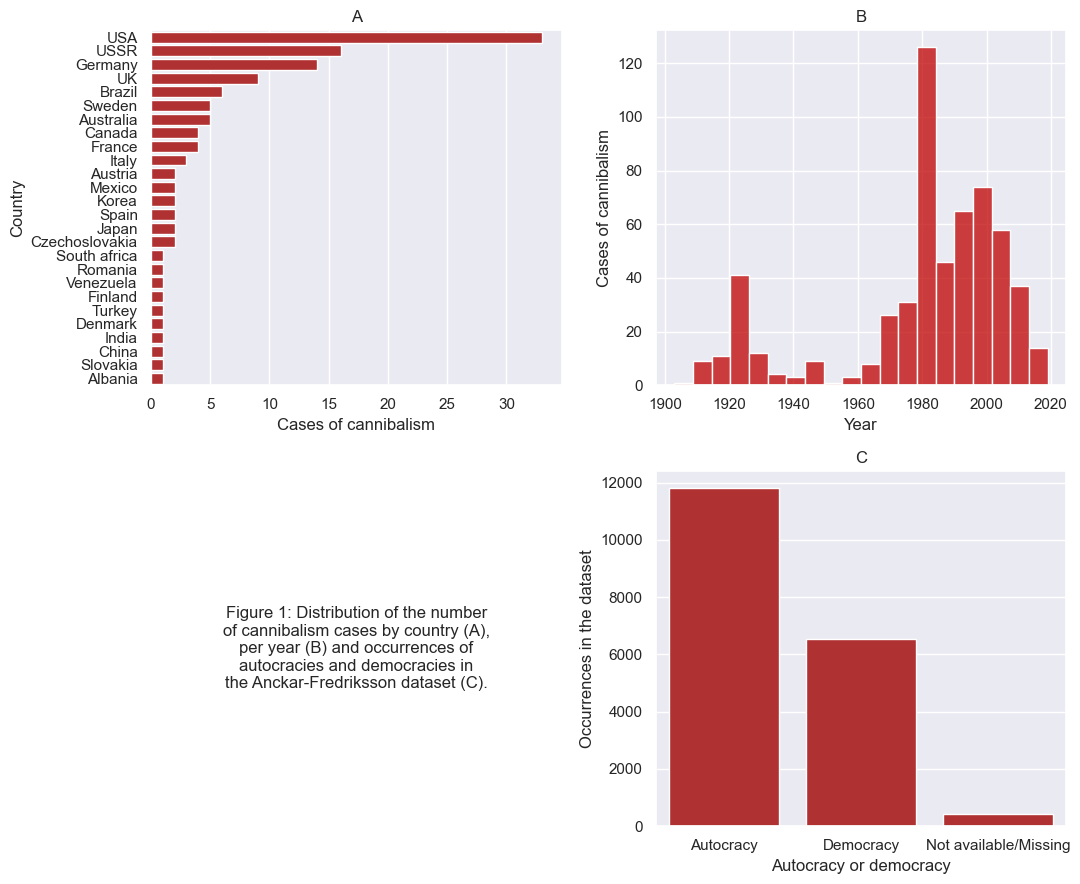

In [10]:
# Creating a panel
plt.figure(figsize=(11, 9))
sns.set(style = "darkgrid")

# Distribution of the number of cannibalism cases by country
plt.subplot(2, 2, 1)
plt.gca().set_title('A')
canni_country = df2['Offender Country'].value_counts()

canni_country.index = canni_country.index.map(lambda x: x.capitalize())
new_names = {'Usa': 'USA',
            'Ussr': 'USSR',
            'Uk': 'UK'}
canni_country = canni_country.rename(index=new_names)

sns.barplot(x = canni_country.values, y = canni_country.index, color = "#c51c1c")
plt.gca().set_xlabel("Cases of cannibalism")
plt.gca().set_ylabel("Country")

# Distribution of the number of cannibalism cases per year
plt.subplot(2, 2, 2)
plt.gca().set_title('B')
sns.histplot(df_merged['year'], bins=20, color = "#c00000")
plt.gca().set_xlabel("Year")
plt.gca().set_ylabel("Cases of cannibalism")

# Occurrences of the autocracies and democracies in the Anckar-Fredriksson dataset
plt.subplot(2, 2, 4)
plt.gca().set_title('C')
demo = df1['democracy'].value_counts()

new_names = {0: 'Autocracy',
            1: 'Democracy',
            99: 'Not available/Missing'}
demo = demo.rename(index=new_names)

sns.barplot(y = demo.values, x = demo.index, color = "#c51c1c")
plt.gca().set_ylabel("Occurrences in the dataset")
plt.gca().set_xlabel("Autocracy or democracy")

# Adding title
plt.subplot(2, 2, 3)
plt.gca().text(0.5, 0.5, 'Figure 1: Distribution of the number\nof cannibalism cases by country (A),\nper year (B) and occurrences of\nautocracies and democracies in\nthe Anckar-Fredriksson dataset (C).', ha='center', va='center', fontsize=12)
plt.gca().axis('off')

# Printing the panel and saving it to jpg
plt.tight_layout()
plt.savefig('cannibalism_fig1.jpg') 
plt.show()

## 5. Data Modelling

*C.f.* the R script for the logistic mixed effects regression.